In [ ]:
import psycopg2
import os
# Replace with your actual PostgreSQL connection string
conn_str = os.environ.get("DATABASE_URL")

# Establish the connection and create a cursor
conn = psycopg2.connect(conn_str)
cursor = conn.cursor()

# Define the SQL query
query = """
SELECT 
    ci.competency_id,
    ci."level",
    string_agg(ci.indicator_en, ' | ') AS indicator_en,
    c.competency_name
FROM competency_indicators ci
LEFT JOIN competency c ON ci.competency_id = c.id
GROUP BY ci.competency_id, ci."level", c.competency_name
ORDER BY ci.competency_id, CASE ci.level
    WHEN 'kennen' THEN 1
    WHEN 'verstehen' THEN 2
    WHEN 'anwenden' THEN 3
    WHEN 'beherrschen' THEN 4
END;
"""

# Execute the query and fetch all rows
cursor.execute(query)
rows = cursor.fetchall()

# Group the rows by competency_id. Each competency is expected to have 4 rows (one per level).
competency_data = {}
for row in rows:
    competency_id = row[0]
    level = row[1].lower()  # normalize level text to lowercase
    indicator = row[2]
    # Initialize the dictionary for a competency if not already present
    if competency_id not in competency_data:
        competency_data[competency_id] = {}
    competency_data[competency_id][level] = indicator

# Build the assessment question for each competency
assessment_dict = {}
for comp_id, levels in competency_data.items():
    kennen = levels.get('kennen', '')
    verstehen = levels.get('verstehen', '')
    anwenden = levels.get('anwenden', '')
    beherrschen = levels.get('beherrschen', '')
    
    question_text = f"""To which of these groups do you identify yourself?
Group 1: {kennen}
Group 2: {verstehen}
Group 3: {anwenden}
Group 4: {beherrschen}
Group 5: I do not see myself in any of the groups"""
    
    assessment_dict[comp_id] = {
        "question_for_assessment": question_text
    }

# Clean up: close the cursor and connection
cursor.close()
conn.close()


In [2]:
assessment_dict

{1: {'question_for_assessment': 'To which of these groups do you identify yourself?\nGroup 1: You are able to recognize the interrelationships of your system and its boundaries.\nGroup 2: You understand the interaction of the individual components that make up the system.\nGroup 3: You are able to analyze your present system and derive continuous improvements from it.\nGroup 4: You are able to carry systemic thinking into the company and inspire others for it.\nGroup 5: I do not see myself in any of the groups'},
 4: {'question_for_assessment': 'To which of these groups do you identify yourself?\nGroup 1: You are able to identify the lifecycle phases of your system.\nGroup 2: You understand why and how all lifecycle phases need to be considered during development.\nGroup 3: You are able to identify, consider, and assess all lifecycle phases relevant to your scope.\nGroup 4: You are able to evaluate concepts regarding the consideration of all lifecycle phases.\nGroup 5: I do not see mys

## LLM assessment

In [ ]:
import os
import json
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from langchain.schema import HumanMessage
from typing import List
import time
import pandas as pd

# Define a model for the survey pitfall assessment result without forced choice.
class SurveyPitfallAssessment(BaseModel):
    competency_id: int = Field(
        description="The unique identifier of the competency."
    )
    question: str = Field(
        description="The question text being assessed."
    )
    pitfall_ambiguous: int = Field(
        description="Binary indicator (1 if ambiguous pitfall exists, 0 otherwise)."
    )
    pitfall_complex: int = Field(
        description="Binary indicator (1 if complex pitfall exists, 0 otherwise)."
    )
    pitfall_double_barrelled: int = Field(
        description="Binary indicator (1 if double-barrelled pitfall exists, 0 otherwise)."
    )
    pitfall_leading: int = Field(
        description="Binary indicator (1 if leading/different wording pitfall exists, 0 otherwise)."
    )

# Initialize the LangChain LLM using Azure OpenAI parameters.
llm = AzureChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.environ.get("AZURE_API_KEY"),
    azure_endpoint=os.environ.get("AZURE_ENDPOINT"),
    api_version="2024-02-15-preview",
    temperature=0.5
)

# Create a version of the LLM that returns structured output using our SurveyPitfallAssessment model.
structured_llm = llm.with_structured_output(SurveyPitfallAssessment)


# New prompt with extra context for clarity.
pitfall_info = """
1. Ambiguous question: A question that can be interpreted in multiple ways.
2. Complex question: A question that is unnecessarily long, has multiple parts, or uses overly complicated language.
   Note: A multiple-choice question that clearly presents several options with brief clarifying descriptions is not inherently complex.
3. Double-barrelled question: A question that asks more than one thing at the same time.
4. Leading question: A question that suggests a particular answer through its wording.
"""

# Iterate over each competency question, send the revised prompt to the LLM, and collect the structured pitfall assessment.
pitfall_assessments = []

for competency_id, data in assessment_dict.items():
    question_text = data["question_for_assessment"]
    prompt = f"""
Competency ID: {competency_id}

We are assessing whether the following multiple-choice survey question—designed to evaluate systems engineering competency—contains any survey pitfalls.

Note:
- This is a standard multiple-choice question where the respondent is required to select one option.
- The question provides clear, distinct groups with brief descriptions to guide the respondent.
- The presence of several groups and descriptive text is normal and does not automatically indicate complexity.

Question:
{question_text}

Below are definitions of potential survey pitfalls:
{pitfall_info}

Please evaluate the question for the following pitfalls:
- Ambiguous question: Does the question have any ambiguity in meaning?
- Complex question: Is the question overly complex in its structure or wording? (Remember, a clear multiple-choice format with defined options should not be considered complex.)
- Double-barrelled question: Does the question ask two or more things at once? In our cases, a single group requiring two seprate 
- Leading question: Does the wording guide the respondent towards a particular answer?

For each pitfall, return 1 if the pitfall exists, or 0 if it does not.
Provide your answer as a JSON object with the following keys:
"competency_id", "question", "pitfall_ambiguous", "pitfall_complex", "pitfall_double_barrelled", "pitfall_leading".
"""
    # Use the structured LLM to process the prompt.
    result = structured_llm.invoke([HumanMessage(content=prompt)])
    pitfall_assessments.append(result)
    
    # Optionally, pause between calls to avoid rate limiting.
    time.sleep(3)



In [9]:
type(pitfall_assessments)

list

In [16]:
# Convert each Pydantic model instance to a dictionary.
serializable_assessments = [assessment.dict() for assessment in pitfall_assessments]


/var/folders/sf/hrd25tt16ll03z02j7dfk2km0000gn/T/ipykernel_30419/2744460748.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  serializable_assessments = [assessment.dict() for assessment in pitfall_assessments]


In [11]:
serializable_assessments

[{'competency_id': 1,
  'question': 'To which of these groups do you identify yourself?\nGroup 1: You are able to recognize the interrelationships of your system and its boundaries.\nGroup 2: You understand the interaction of the individual components that make up the system.\nGroup 3: You are able to analyze your present system and derive continuous improvements from it.\nGroup 4: You are able to carry systemic thinking into the company and inspire others for it.\nGroup 5: I do not see myself in any of the groups',
  'pitfall_ambiguous': 0,
  'pitfall_complex': 0,
  'pitfall_double_barrelled': 1,
  'pitfall_leading': 0},
 {'competency_id': 4,
  'question': 'To which of these groups do you identify yourself? Group 1: You are able to identify the lifecycle phases of your system. Group 2: You understand why and how all lifecycle phases need to be considered during development. Group 3: You are able to identify, consider, and assess all lifecycle phases relevant to your scope. Group 4: Yo

In [ ]:
serializable_assessments

In [17]:
# Save the results to a JSON file.
output_filename = "pitfall_assessments.json"
with open(output_filename, "w") as f:
    json.dump(serializable_assessments, f, indent=2)

print(f"Results saved to {output_filename}")

Results saved to pitfall_assessments.json


# Analysis

Pitfall counts: {'pitfall_ambiguous': 0, 'pitfall_complex': 0, 'pitfall_double_barrelled': 0, 'pitfall_leading': 0}


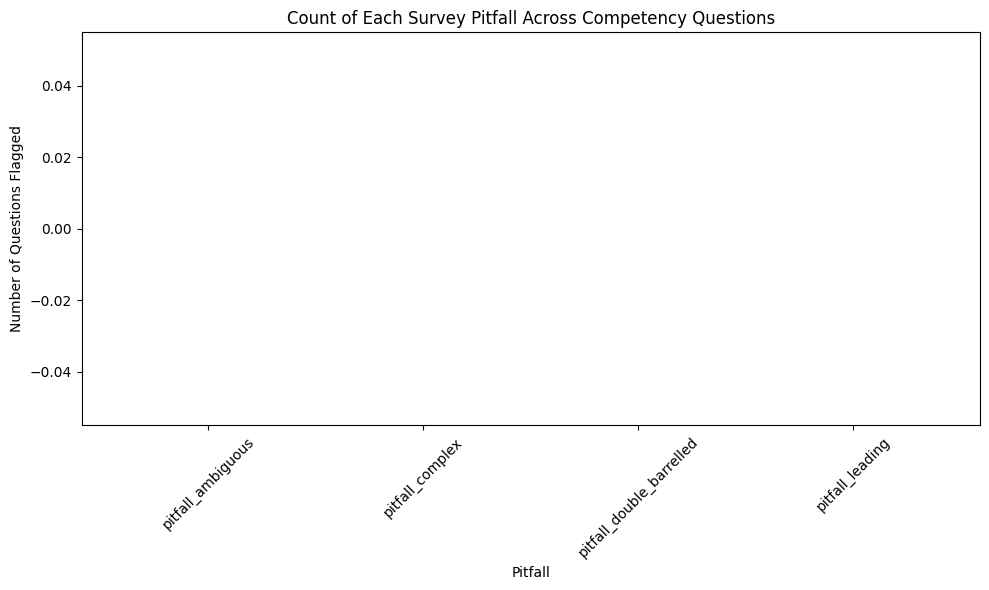

In [19]:
import json
import matplotlib.pyplot as plt

# Load the pitfall assessments from the JSON file.
with open("pitfall_assessments.json", "r") as f:
    assessments = json.load(f)

# Define the pitfall keys.
pitfalls = ["pitfall_ambiguous", "pitfall_complex", "pitfall_double_barrelled", "pitfall_leading"]

# Initialize a dictionary to store the count of flagged pitfalls.
pitfall_counts = {pitfall: 0 for pitfall in pitfalls}

# Iterate over each assessment and count the flagged pitfalls.
for assessment in assessments:
    for pitfall in pitfalls:
        if assessment.get(pitfall, 0) == 1:
            pitfall_counts[pitfall] += 1

print("Pitfall counts:", pitfall_counts)

# Visualize the counts using a bar chart.
plt.figure(figsize=(10, 6))
plt.bar(pitfall_counts.keys(), pitfall_counts.values(), color='skyblue')
plt.title("Count of Each Survey Pitfall Across Competency Questions")
plt.xlabel("Pitfall")
plt.ylabel("Number of Questions Flagged")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
